In [1]:
import copy
import re
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    save_circuit,
    create_dir,
    get_random_state
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime

%matplotlib inline

In [3]:
results_dir = "results/runs_shell"
run_range = list(range(1, 11))
qubit_range = [3, 4, 5, 6, 7, 8]

# EPS values are mapped separately
#eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
eps_values = [0.5, 0.1, 0.05, 0.01]

### Random State type

Creating pandas dataframe

Creating result dictionaries

In [66]:
state_type = "lognormal"

In [67]:
#[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
original_results_dict = {
    "num_qubits": [],
    0.5: [],
    0.1: [],
    0.05: [],
    0.01: [],
}

modified_results_dict = copy.deepcopy(original_results_dict)

for (r_dir, st_type, num_qubits, eps) in product([results_dir], [state_type], qubit_range, eps_values):
    if not num_qubits in original_results_dict["num_qubits"]: 
        original_results_dict["num_qubits"] += [num_qubits]
        modified_results_dict["num_qubits"] += [num_qubits]

    original_results_dict[eps] += [[]]
    modified_results_dict[eps] += [[]]

    for run_idx in run_range:
        fid_loss_original = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
        original_results_dict[eps][-1] += [data_original.round(4)]

        fid_loss_modified = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
        modified_results_dict[eps][-1]+= [data_modified.round(4)]

In [68]:
default_dict = {
    "num_qubits": qubit_range,
    0.5: [],
    0.1: [],
    0.05: [],
    0.01: [],
}
mean_original_results_dict = copy.deepcopy(default_dict)
mean_modified_results_dict = copy.deepcopy(default_dict)

stds_original_results_dict = copy.deepcopy(default_dict)
stds_modified_results_dict = copy.deepcopy(default_dict)

for eps in eps_values:
    mean_original_results_dict[eps] = np.mean(original_results_dict[eps], axis=1)
    stds_original_results_dict[eps] = np.std(original_results_dict[eps], axis=1).round(2)

    mean_modified_results_dict[eps] = np.mean(modified_results_dict[eps], axis=1)
    stds_modified_results_dict[eps] = np.std(modified_results_dict[eps], axis=1).round(2)

Original fidloss

In [69]:
df_mean_original = pd.DataFrame(mean_original_results_dict)
df_mean_original = df_mean_original.set_index("num_qubits")
display(df_mean_original)

df_stds_original = pd.DataFrame(stds_original_results_dict)
df_stds_original = df_stds_original.set_index("num_qubits")
df_stds_original

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00975,0.0022,0.00774,0.01289
4,0.04520,0.0452,0.00357,0.02590
5,0.28450,0.2845,0.03484,0.01933
6,0.26790,0.2679,0.26212,0.04967
7,0.25380,0.2538,0.24950,0.25473
8,0.24570,0.2457,0.24550,0.24220


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02,0.0,0.0,0.02
4,0.00,0.0,0.0,0.05
5,0.00,0.0,0.0,0.03
6,0.00,0.0,0.0,0.03
7,0.00,0.0,0.0,0.02
8,0.00,0.0,0.0,0.00


In [70]:
print(df_mean_original.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrr}
\toprule
 & 0.500000 & 0.100000 & 0.050000 & 0.010000 \\
num_qubits &  &  &  &  \\
\midrule
3 & 0.0097 & 0.0022 & 0.0077 & 0.0129 \\
4 & 0.0452 & 0.0452 & 0.0036 & 0.0259 \\
5 & 0.2845 & 0.2845 & 0.0348 & 0.0193 \\
6 & 0.2679 & 0.2679 & 0.2621 & 0.0497 \\
7 & 0.2538 & 0.2538 & 0.2495 & 0.2547 \\
8 & 0.2457 & 0.2457 & 0.2455 & 0.2422 \\
\bottomrule
\end{tabular}



Modified fidloss

In [71]:
df_mean_modified = pd.DataFrame(mean_modified_results_dict)
df_mean_modified = df_mean_modified.set_index("num_qubits")
display(df_mean_modified)

df_stds_modified = pd.DataFrame(stds_modified_results_dict)
df_stds_modified = df_stds_modified.set_index("num_qubits")
df_stds_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00183,0.00250,0.00809,0.01338
4,0.04801,0.04814,0.00721,0.01093
5,0.28000,0.28000,0.05430,0.01801
6,0.14943,0.05559,0.26394,0.05516
7,0.25230,0.25230,0.02340,0.25273
8,0.05147,0.14459,0.04447,0.04389


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00,0.00,0.00,0.02
4,0.01,0.00,0.01,0.01
5,0.00,0.00,0.00,0.03
6,0.28,0.00,0.00,0.01
7,0.00,0.00,0.00,0.02
8,0.01,0.29,0.00,0.03


In [72]:
print(df_mean_modified.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrr}
\toprule
 & 0.500000 & 0.100000 & 0.050000 & 0.010000 \\
num_qubits &  &  &  &  \\
\midrule
3 & 0.0018 & 0.0025 & 0.0081 & 0.0134 \\
4 & 0.0480 & 0.0481 & 0.0072 & 0.0109 \\
5 & 0.2800 & 0.2800 & 0.0543 & 0.0180 \\
6 & 0.1494 & 0.0556 & 0.2639 & 0.0552 \\
7 & 0.2523 & 0.2523 & 0.0234 & 0.2527 \\
8 & 0.0515 & 0.1446 & 0.0445 & 0.0439 \\
\bottomrule
\end{tabular}



Counting depth

In [73]:
depth_count_original = []
depth_count_modified = []

for qb_idx, num_qubits in enumerate(qubit_range):
    depth_count_original += [[]]
    depth_count_modified += [[]]

    for eps in eps_values:
        #circuit = load_circuit(f"results/circuits/curcuit_{num_qubits}qb_{eps}eps.pkl")
        state = get_random_state(num_qubits)

        # original
        ansatz = SanchezAnsatz(state, eps)
        to_ansatz = transpile(ansatz, basis_gates=["cx", "u"])
        depth_count_original[qb_idx] += [to_ansatz.depth()]

        # modified
        mod_ansatz = SanchezAnsatz(state, eps, build_modified=True)
        tm_ansatz = transpile(mod_ansatz, basis_gates=["cx", "u"])
        depth_count_modified[qb_idx] += [tm_ansatz.depth()]


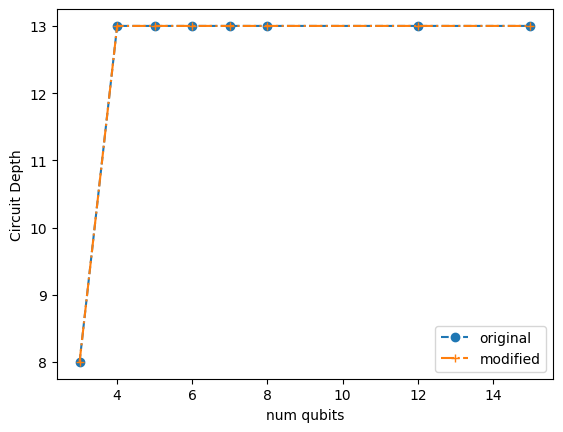

In [95]:
mean_depth_original = np.mean(depth_count_original, axis=1, dtype=np.int32)
mean_depth_modified = np.mean(depth_count_modified, axis=1, dtype=np.int32)

plt.plot(qubit_range, mean_depth_original, "--", marker="o", label='original')
plt.plot(qubit_range, mean_depth_modified, "-.", marker="+", label="modified")
plt.xlabel("num qubits")
plt.ylabel("Circuit Depth")
plt.legend(loc="best")
plt.plot()
plt.savefig(f"{results_dir}/mean_circuit_depth.pdf")